# **COVID-19 Data Analysis Project**

---

`Team: Keerthi, Hossein, Sathiya, Siva, Tejo`

## Overview

This notebook presents a comprehensive analysis of COVID-19 data to uncover key trends, forecast future case numbers, and provide insights into the pandemic's impact globally. Our aim is to leverage data-driven approaches to better understand the spread and implications of COVID-19, aiding in informed decision-making for healthcare and policy planning.

## Scope of Analysis

- **Data Exploration**: Conduct exploratory data analysis (EDA) to understand the dataset's characteristics and uncover initial patterns.
- **Trend Analysis**: Analyze trends in COVID-19 cases and deaths over time and across different geographical regions.
- **Predictive Modeling**: Build and evaluate predictive models to forecast the future trajectory of the pandemic.
- **Impact Assessment**: Assess the impact of various factors such as vaccination rates, public health policies, and demographic variables on COVID-19 trends.


## Data Sources

Our analysis utilizes data from the following sources:

- [Johns Hopkins University COVID-19 Data Repository](https://github.com/CSSEGISandData/COVID-19): Provides daily updates on COVID-19 cases and deaths worldwide.
- [Our World in Data COVID-19 Dataset](https://ourworldindata.org/coronavirus): Offers extensive data on COVID-19 vaccinations, testing, and other relevant metrics.

## Methodologies Used

- **Data Cleaning and Preprocessing**: Standardizing data formats, handling missing values, and data normalization.
- **Statistical Analysis and Visualization**: Using statistical methods and visualization tools to interpret data trends and patterns.
- **Machine Learning**: Implementing models like SARIMA, Random Forest, and Neural Networks for time series forecasting.
- **MLflow for Experiment Tracking**: Utilizing MLflow to track experiments, log model parameters, and evaluate model performance.

# ***Setup - Installs and Imports***

In [ ]:
!pip install mlflow --quiet
!pip install pyngrok --quiet
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
import geopandas as gpd
import mlflow
from pyngrok import ngrok
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error
from pmdarima import auto_arima

# ***Data Extraction & Cleaning***

In [ ]:
# Function to generate dates in the desired range
def generate_dates(start_date, end_date):
    current_date = datetime.strptime(start_date, '%m-%d-%Y')
    end_date = datetime.strptime(end_date, '%m-%d-%Y')
    while current_date <= end_date:
        yield current_date.strftime('%m-%d-%Y')
        current_date += timedelta(days=1)

# Generate list of filenames
start_date = '05-01-2021'
end_date = '09-30-2022'
filenames = [f"{date}.csv" for date in generate_dates(start_date, end_date)]

base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/"

dataframes = []
for filename in filenames:
    try:
        df = pd.read_csv(base_url + filename)
        dataframes.append(df)
    except FileNotFoundError:
        print(f"File not found: {filename}")

# Concatenate all dataframes
combined_df = pd.concat(dataframes)

combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df.sort_values(by='Date', inplace=True)

In [ ]:
combined_df.Date.unique()

array(['2021-05-01T00:00:00.000000000', '2021-05-02T00:00:00.000000000',
       '2021-05-03T00:00:00.000000000', '2021-05-04T00:00:00.000000000',
       '2021-05-05T00:00:00.000000000', '2021-05-06T00:00:00.000000000',
       '2021-05-07T00:00:00.000000000', '2021-05-08T00:00:00.000000000',
       '2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000',
       '2021-05-19T00:00:00.000000000', '2021-05-20T00:00:00.000000000',
       '2021-05-21T00:00:00.000000000', '2021-05-22T00:00:00.000000000',
       '2021-05-23T00:00:00.000000000', '2021-05-24T00:00:00.000000000',
       '2021-05-25T00:00:00.000000000', '2021-05-26T00:00:00.000000000',
       '2021-05-27T00:00:00.000000000', '2021-05-28

In [ ]:
# Count nulls in the 'Date' column
null_count = combined_df['Date'].isna().sum()
print(f"Number of nulls in Date column in JHU data: {null_count}")

Number of nulls in Date column in JHU data: 580


In [ ]:
combined_df.reset_index(drop=True, inplace=True)

# Convert Last_Updated_Time to datetime
combined_df['Last_Update'] = pd.to_datetime(combined_df['Last_Update'])

# Update Date where it's Naand Last_Updated_Time is not empty
combined_df.loc[combined_df['Date'].isna() & combined_df['Last_Update'].notna(), 'Date'] = combined_df['Last_Update'].dt.date - pd.Timedelta(days=1)

In [ ]:
combined_df.tail(n=10)

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,...,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,Hospitalization_Rate,Date,People_Tested,Mortality_Rate
30004,Indiana,US,2022-10-01 04:31:49,39.8494,-86.2583,1921993,24708,NaN,NaN,18.0,...,NaN,NaN,1.285541,84000018.0,USA,NaN,NaN,2022-09-30,NaN,NaN
30005,Iowa,US,2022-10-01 04:31:49,42.0115,-93.2105,856096,10077,NaN,NaN,19.0,...,NaN,NaN,1.177088,84000019.0,USA,NaN,NaN,2022-09-30,NaN,NaN
30006,Kansas,US,2022-10-01 04:31:49,38.5266,-96.7265,878782,9555,NaN,NaN,20.0,...,NaN,NaN,1.087029,84000020.0,USA,NaN,NaN,2022-09-30,NaN,NaN
30007,Kentucky,US,2022-10-01 04:31:49,37.6681,-84.6701,1582021,17004,NaN,NaN,21.0,...,NaN,NaN,1.074828,84000021.0,USA,NaN,NaN,2022-09-30,NaN,NaN
30008,Louisiana,US,2022-10-01 04:31:49,31.1695,-91.8678,1455290,18066,NaN,NaN,22.0,...,NaN,NaN,1.241402,84000022.0,USA,NaN,NaN,2022-09-30,NaN,NaN
30009,Maine,US,2022-10-01 04:31:49,44.6939,-69.3819,289726,2580,NaN,NaN,23.0,...,NaN,NaN,0.890497,84000023.0,USA,NaN,NaN,2022-09-30,NaN,NaN
30010,Maryland,US,2022-10-01 04:31:49,39.0639,-76.8021,1250032,15399,NaN,NaN,24.0,...,NaN,NaN,1.231888,84000024.0,USA,NaN,NaN,2022-09-30,NaN,NaN
30011,Massachusetts,US,2022-10-01 04:31:49,42.2302,-71.5301,2050942,21706,NaN,NaN,25.0,...,NaN,NaN,1.058343,84000025.0,USA,NaN,NaN,2022-09-30,NaN,NaN
30012,Michigan,US,2022-10-01 04:31:49,43.3266,-84.5361,2836167,38624,NaN,NaN,26.0,...,NaN,NaN,1.361838,84000026.0,USA,NaN,NaN,2022-09-30,NaN,NaN
30013,Minnesota,US,2022-10-01 04:31:49,45.6945,-93.9002,1664797,13651,NaN,NaN,27.0,...,NaN,NaN,0.819980,84000027.0,USA,NaN,NaN,2022-09-30,NaN,NaN


In [ ]:
# Calculating daily deaths by state
combined_df['Daily_Deaths'] = combined_df.groupby('Province_State')['Deaths'].diff().fillna(0)

# Calculating daily cases by state
combined_df['Daily_ConfirmedCases'] = combined_df.groupby('Province_State')['Confirmed'].diff().fillna(0)

In [ ]:
# Replacing the original 'Deaths' column with these values
combined_df['Deaths'] = combined_df['Daily_Deaths']
del combined_df['Daily_Deaths']

# Replacing the original 'confirmed' column with these values
combined_df['Confirmed'] = combined_df['Daily_ConfirmedCases']
del combined_df['Daily_ConfirmedCases']

In [ ]:
# Counting the number of rows where Deaths and Cases is negative
negative_cases_count = (combined_df['Confirmed'] < 0).sum()
negative_deaths_count = (combined_df['Deaths'] < 0).sum()

print(f"Number of rows with negative deaths: {negative_deaths_count}")
print(f"Number of rows with negative cases: {negative_cases_count}")

Number of rows with negative deaths: 172
Number of rows with negative cases: 67


In [ ]:
combined_df['Deaths'] = combined_df['Deaths'].clip(lower=0)

combined_df['Confirmed'] = combined_df['Confirmed'].clip(lower=0)

In [ ]:
# Removing rows where Province_State is not right
combined_df = combined_df[~combined_df['Province_State'].isin(['Grand Princess', 'Diamond Princess'])]

In [ ]:
combined_df['FIPS'] = pd.to_numeric(combined_df['FIPS'], errors='coerce').fillna(0).astype(int).astype(str)

combined_df['Deaths'] = pd.to_numeric(combined_df['Deaths'], errors='coerce').fillna(0).astype(int)

combined_df['Confirmed'] = pd.to_numeric(combined_df['Confirmed'], errors='coerce').fillna(0).astype(int)

<ipython-input-57-47fa854aff07>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['FIPS'] = pd.to_numeric(combined_df['FIPS'], errors='coerce').fillna(0).astype(int).astype(str)
<ipython-input-57-47fa854aff07>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['Deaths'] = pd.to_numeric(combined_df['Deaths'], errors='coerce').fillna(0).astype(int)
<ipython-input-57-47fa854aff07>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [ ]:
combined_df = combined_df[['Deaths', 'Confirmed', 'Province_State', 'Date', 'FIPS', 'Lat', 'Long_']]

combined_df.to_csv('StateWiseDeaths.csv', index=False)

In [ ]:
combined_df.Date.unique()

array(['2021-05-01T00:00:00.000000000', '2021-05-02T00:00:00.000000000',
       '2021-05-03T00:00:00.000000000', '2021-05-04T00:00:00.000000000',
       '2021-05-05T00:00:00.000000000', '2021-05-06T00:00:00.000000000',
       '2021-05-07T00:00:00.000000000', '2021-05-08T00:00:00.000000000',
       '2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000',
       '2021-05-19T00:00:00.000000000', '2021-05-20T00:00:00.000000000',
       '2021-05-21T00:00:00.000000000', '2021-05-22T00:00:00.000000000',
       '2021-05-23T00:00:00.000000000', '2021-05-24T00:00:00.000000000',
       '2021-05-25T00:00:00.000000000', '2021-05-26T00:00:00.000000000',
       '2021-05-27T00:00:00.000000000', '2021-05-28

In [ ]:
combined_df.loc[combined_df['Province_State']=='California']

,Deaths,Confirmed,Province_State,Date,FIPS,Lat,Long_
35,0,0,California,2021-05-01,6,36.1162,-119.6816
92,45,1634,California,2021-05-02,6,36.1162,-119.6816
153,2,1477,California,2021-05-03,6,36.1162,-119.6816
209,51,1626,California,2021-05-04,6,36.1162,-119.6816
268,58,1574,California,2021-05-05,6,36.1162,-119.6816
...,...,...,...,...,...,...,...
29759,33,3525,California,2022-09-26,6,36.1162,-119.6816
29817,11,16645,California,2022-09-27,6,36.1162,-119.6816
29875,26,1588,California,2022-09-28,6,36.1162,-119.6816
29933,154,7675,California,2022-09-29,6,36.1162,-119.6816


In [ ]:
cdc_data_df = pd.read_csv('cdc_updated_data.csv')

In [ ]:
cdc_data_df

,Date,FIPS,Recip_State,Recip_County,Booster_Doses_18Plus,Series_Complete_18Plus,Administered_Dose1_Recip_18Plus,Census2019_18PlusPop,Series_Complete_65Plus,Administered_Dose1_Recip_65Plus
0,05/02/2021,48213,TX,Henderson County,NaN,0.0,0.0,65135.0,0.0,0.0
1,05/02/2021,08055,CO,Huerfano County,NaN,903.0,1180.0,5787.0,273.0,349.0
2,05/02/2021,26099,MI,Macomb County,NaN,256886.0,344023.0,692171.0,102802.0,115697.0
3,05/02/2021,21111,KY,Jefferson County,NaN,274842.0,343692.0,598182.0,91994.0,104029.0
4,05/02/2021,20037,KS,Crawford County,NaN,10965.0,12687.0,30346.0,4075.0,4381.0
...,...,...,...,...,...,...,...,...,...,...
1398448,09/28/2022,48229,TX,Hudspeth County,1052.0,2779.0,3235.0,3869.0,450.0,524.0
1398449,09/28/2022,72017,PR,Barceloneta Municipio,10336.0,15951.0,17762.0,19327.0,3894.0,4406.0
1398450,09/28/2022,31077,NE,Greeley County,607.0,920.0,NaN,1815.0,359.0,NaN
1398451,09/28/2022,18171,IN,Warren County,1773.0,3630.0,4002.0,6429.0,1286.0,1380.0


In [ ]:
cdc_data_df['Date'] = pd.to_datetime(cdc_data_df['Date'])

print(cdc_data_df['Date'].min())
print(cdc_data_df['Date'].max())

2021-05-02 00:00:00
2022-09-28 00:00:00


In [ ]:
cdc_data_df.Date.unique()

array(['2021-05-02T00:00:00.000000000', '2021-05-03T00:00:00.000000000',
       '2021-05-04T00:00:00.000000000', '2021-05-05T00:00:00.000000000',
       '2021-05-06T00:00:00.000000000', '2021-05-07T00:00:00.000000000',
       '2021-05-08T00:00:00.000000000', '2021-05-09T00:00:00.000000000',
       '2021-05-10T00:00:00.000000000', '2021-05-11T00:00:00.000000000',
       '2021-05-12T00:00:00.000000000', '2021-05-13T00:00:00.000000000',
       '2021-05-14T00:00:00.000000000', '2021-05-15T00:00:00.000000000',
       '2021-05-16T00:00:00.000000000', '2021-05-17T00:00:00.000000000',
       '2021-05-18T00:00:00.000000000', '2021-05-19T00:00:00.000000000',
       '2021-05-20T00:00:00.000000000', '2021-05-21T00:00:00.000000000',
       '2021-05-22T00:00:00.000000000', '2021-05-23T00:00:00.000000000',
       '2021-05-24T00:00:00.000000000', '2021-05-25T00:00:00.000000000',
       '2021-05-26T00:00:00.000000000', '2021-05-27T00:00:00.000000000',
       '2021-05-28T00:00:00.000000000', '2021-05-29

In [ ]:
cdc_data_df['State_FIPS'] = cdc_data_df['FIPS'].str[:2]

In [ ]:
# Replace NaN values with 0 in all columns
cdc_data_df.fillna(0, inplace=True)

In [ ]:
cdc_data_df['Administered_Doses_18Plus_Daily'] = cdc_data_df.groupby(['State_FIPS', 'FIPS'])['Administered_Dose1_Recip_18Plus'].diff().fillna(0)

cdc_data_df['Series_Complete_18Plus_Daily'] = cdc_data_df.groupby(['State_FIPS', 'FIPS'])['Series_Complete_18Plus'].diff().fillna(0)

cdc_data_df['Booster_Doses_18Plus_Daily'] = cdc_data_df.groupby(['State_FIPS', 'FIPS'])['Booster_Doses_18Plus'].diff().fillna(0)

cdc_data_df['Series_Complete_65Plus_Daily'] = cdc_data_df.groupby(['State_FIPS', 'FIPS'])['Series_Complete_65Plus'].diff().fillna(0)

cdc_data_df['Administered_Doses_65Plus_Daily'] = cdc_data_df.groupby(['State_FIPS', 'FIPS'])['Administered_Dose1_Recip_65Plus'].diff().fillna(0)


In [ ]:
# List of specific columns to update
columns_to_update = ['Administered_Doses_65Plus_Daily', 'Series_Complete_65Plus_Daily', 'Booster_Doses_18Plus_Daily',
                     'Series_Complete_18Plus_Daily', 'Administered_Doses_18Plus_Daily']

# Replacing negative values in specific columns with 0
for col in columns_to_update:
    cdc_data_df[col] = cdc_data_df[col].clip(lower=0)

In [ ]:
# Count nulls in a 'Date' column
null_count = cdc_data_df['Date'].isna().sum()
print(f"Number of nulls in Date column in CDC data: {null_count}")

Number of nulls in Date column in CDC data: 0


In [ ]:
new_df = cdc_data_df.groupby(['Date', 'State_FIPS']).agg({
    'Administered_Doses_65Plus_Daily':'sum',
    'Series_Complete_65Plus_Daily':'sum',
    'Booster_Doses_18Plus_Daily':'sum',
    'Series_Complete_18Plus_Daily':'sum',
    'Administered_Doses_18Plus_Daily':'sum',
    'Census2019_18PlusPop':'sum'
})

In [ ]:
new_df = new_df.reset_index()

In [ ]:
new_df

,Date,State_FIPS,Administered_Doses_65Plus_Daily,Series_Complete_65Plus_Daily,Booster_Doses_18Plus_Daily,Series_Complete_18Plus_Daily,Administered_Doses_18Plus_Daily,Census2019_18PlusPop
0,2021-05-02,01,0.0,0.0,0.0,0.0,0.0,3814879.0
1,2021-05-02,02,0.0,0.0,0.0,0.0,0.0,551562.0
2,2021-05-02,04,0.0,0.0,0.0,0.0,0.0,5638481.0
3,2021-05-02,05,0.0,0.0,0.0,0.0,0.0,2317649.0
4,2021-05-02,06,0.0,0.0,0.0,0.0,0.0,30617582.0
...,...,...,...,...,...,...,...,...
23425,2022-09-28,56,161.0,127.0,428.0,272.0,407.0,445025.0
23426,2022-09-28,66,0.0,3.0,5.0,8.0,0.0,114544.0
23427,2022-09-28,72,806.0,1458.0,8215.0,5671.0,3690.0,2620963.0
23428,2022-09-28,78,100.0,41.0,3.0,66.0,187.0,0.0


In [ ]:
# remove bad data
new_df = new_df[~new_df['State_FIPS'].isin(['78', 'UN'])]

In [ ]:
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

In [ ]:
# Merge the dataframes on State FIPS and Date
merged_df = pd.merge(new_df, combined_df, left_on=['State_FIPS', 'Date'], right_on=['FIPS', 'Date'])

In [ ]:
merged_df.columns

Index(['Date', 'State_FIPS', 'Administered_Doses_65Plus_Daily',
       'Series_Complete_65Plus_Daily', 'Booster_Doses_18Plus_Daily',
       'Series_Complete_18Plus_Daily', 'Administered_Doses_18Plus_Daily',
       'Census2019_18PlusPop', 'Deaths', 'Confirmed', 'Province_State', 'FIPS',
       'Lat', 'Long_'],
      dtype='object')

In [ ]:
merged_df.to_csv('final_merged_df.csv', index=False)

In [ ]:
merged_df.tail(n=10)

,Date,State_FIPS,Administered_Doses_65Plus_Daily,Series_Complete_65Plus_Daily,Booster_Doses_18Plus_Daily,Series_Complete_18Plus_Daily,Administered_Doses_18Plus_Daily,Census2019_18PlusPop,Deaths,Confirmed,Province_State,FIPS,Lat,Long_
19546,2022-09-21,55,596.0,607.0,2602.0,2085.0,2403.0,4555837.0,2,1508,Wisconsin,55,44.2685,-89.6165
19547,2022-09-21,56,84.0,84.0,297.0,222.0,315.0,445025.0,0,0,Wyoming,56,42.7560,-107.3025
19548,2022-09-21,66,0.0,1.0,4.0,3.0,0.0,114544.0,5,22,Guam,66,13.4443,144.7937
19549,2022-09-21,72,1230.0,1460.0,7520.0,4824.0,4118.0,2620963.0,8,0,Puerto Rico,72,18.2208,-66.5901
19550,2022-09-28,10,532.0,458.0,1725.0,1210.0,1394.0,770192.0,0,215,Delaware,10,39.3185,-75.5071
19551,2022-09-28,11,430.0,303.0,2316.0,2238.0,2800.0,577581.0,0,58,District of Columbia,11,38.8974,-77.0268
19552,2022-09-28,12,4360.0,4671.0,16144.0,11456.0,14141.0,17247808.0,47,0,Florida,12,27.7663,-81.6868
19553,2022-09-28,13,714.0,1261.0,10808.0,4757.0,3303.0,8113542.0,110,5046,Georgia,13,33.0406,-83.6431
19554,2022-09-28,15,0.0,0.0,0.0,0.0,0.0,1116004.0,7,12755,Hawaii,15,21.0943,-157.4983
19555,2022-09-28,16,327.0,364.0,1650.0,950.0,1126.0,1338864.0,5,593,Idaho,16,44.2405,-114.4788


# **EDA & Viz**




In [ ]:
df1 = pd.read_csv('final_merged_df.csv')

In [ ]:
df1.columns

Index(['Date', 'State_FIPS', 'Administered_Doses_65Plus_Daily',
       'Series_Complete_65Plus_Daily', 'Booster_Doses_18Plus_Daily',
       'Series_Complete_18Plus_Daily', 'Administered_Doses_18Plus_Daily',
       'Census2019_18PlusPop', 'Deaths', 'Confirmed', 'Province_State', 'FIPS',
       'Lat', 'Long_'],
      dtype='object')

In [ ]:
top_10_states = df1.groupby('Province_State')['Series_Complete_18Plus_Daily'].sum().nlargest(10).index

In [ ]:
top_10_states

Index(['Texas', 'Florida', 'New York', 'Pennsylvania', 'Illinois', 'Georgia',
       'Virginia', 'Ohio', 'New Jersey', 'North Carolina'],
      dtype='object', name='Province_State')

In [ ]:
top_10_states_data = df1[df1['Province_State'].isin(top_10_states)]

In [ ]:
top_10_states_data

,Date,State_FIPS,Administered_Doses_65Plus_Daily,Series_Complete_65Plus_Daily,Booster_Doses_18Plus_Daily,Series_Complete_18Plus_Daily,Administered_Doses_18Plus_Daily,Census2019_18PlusPop,Deaths,Confirmed,Province_State,FIPS,Lat,Long_
2,2021-05-02,12,0.0,0.0,0.0,0.0,0.0,17247808.0,29,3841,Florida,12,27.7663,-81.6868
3,2021-05-02,13,0.0,0.0,0.0,0.0,0.0,8113542.0,0,1302,Georgia,13,33.0406,-83.6431
6,2021-05-02,17,0.0,0.0,0.0,0.0,0.0,9853946.0,28,1860,Illinois,17,40.3495,-88.9861
23,2021-05-02,34,0.0,0.0,0.0,0.0,0.0,6943612.0,12,1198,New Jersey,34,40.2989,-74.5210
25,2021-05-02,36,0.0,0.0,0.0,0.0,0.0,15425262.0,50,2826,New York,36,42.1657,-74.9481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19576,2022-09-28,37,10916.0,9812.0,21799.0,21584.0,26291.0,8187369.0,67,16091,North Carolina,37,35.6301,-79.8064
19578,2022-09-28,39,1532.0,1449.0,8051.0,4460.0,5501.0,9111081.0,15,0,Ohio,39,40.3888,-82.7649
19581,2022-09-28,42,1767.0,1222.0,2473.0,3845.0,5647.0,10167376.0,115,14210,Pennsylvania,42,40.5908,-77.2098
19586,2022-09-28,48,2343.0,2365.0,14535.0,9434.0,13554.0,21596071.0,4,675,Texas,48,31.0545,-97.5635


In [ ]:
bubble_chart_data_top_10 = top_10_states_data.groupby('Province_State').agg({
    'Administered_Doses_18Plus_Daily': 'sum',
    'Series_Complete_18Plus_Daily': 'sum',
    'Deaths': 'sum',
    'Census2019_18PlusPop': 'mean'
}).reset_index()

In [ ]:
fig = px.scatter(bubble_chart_data_top_10, x='Administered_Doses_18Plus_Daily', y='Series_Complete_18Plus_Daily',
                 size='Census2019_18PlusPop', color='Province_State', hover_name='Province_State',
                 log_x=True, log_y=True, size_max=60,
                 title='Relationship Between Administered Doses, Completed Vaccine Series, and Deaths for Top 10 States',
                 labels={'Administered_Doses_18Plus_Daily': 'Total Administered Doses',
                         'Series_Complete_18Plus_Daily': 'Total Completed Series',
                         'Census2019_18PlusPop': '18+ Population'})
fig.show()

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

# Aggregate data by date for time series analysis
df_grouped_date = df.groupby('Date').sum().reset_index()

# Creating time series plot with Plotly
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df_grouped_date['Date'], y=df_grouped_date['Administered_Doses_18Plus_Daily'], name="Administered Doses 18+"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_grouped_date['Date'], y=df_grouped_date['Deaths'], name="Deaths"),
    secondary_y=True,
)

fig.update_layout(
    title_text="COVID-19 Vaccination (18+) and Deaths Over Time"
)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Administered Doses (18+)", secondary_y=False)
fig.update_yaxes(title_text="Deaths", secondary_y=True)

fig.show()

<ipython-input-2-d2ef751b2a98>:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped_date = df.groupby('Date').sum().reset_index()


In [ ]:
# Total administered doses divided by the adult population (18+)
df['Vaccination_Rate'] = df['Administered_Doses_18Plus_Daily'] / df['Census2019_18PlusPop']

# For death rate:
# Total deaths divided by the adult population (18+)
df['Death_Rate'] = df['Deaths'] / df['Census2019_18PlusPop']

# Top 10 states by vaccination rate
top_10_vaccination_states = df.sort_values(by='Vaccination_Rate', ascending=False).head(10)

# Bottom 10 states by death rate
bottom_10_death_states = df.sort_values(by='Death_Rate').head(10)

# Combining the top 10 vaccination states and bottom 10 death states for the scatter plot
selected_states = pd.concat([top_10_vaccination_states, bottom_10_death_states]).drop_duplicates()

# Displaying the lists of top 10 and bottom 10 states
top_10_vaccination_states_list = top_10_vaccination_states['Province_State'].tolist()
bottom_10_death_states_list = bottom_10_death_states['Province_State'].tolist()

top_10_vaccination_states_list, bottom_10_death_states_list


(['Rhode Island',
  'Texas',
  'New Mexico',
  'New Hampshire',
  'South Dakota',
  'Ohio',
  'Nebraska',
  'Michigan',
  'West Virginia',
  'Georgia'],
 ['Delaware',
  'North Carolina',
  'Oregon',
  'Hawaii',
  'Rhode Island',
  'South Carolina',
  'South Dakota',
  'Utah',
  'Vermont',
  'Guam'])

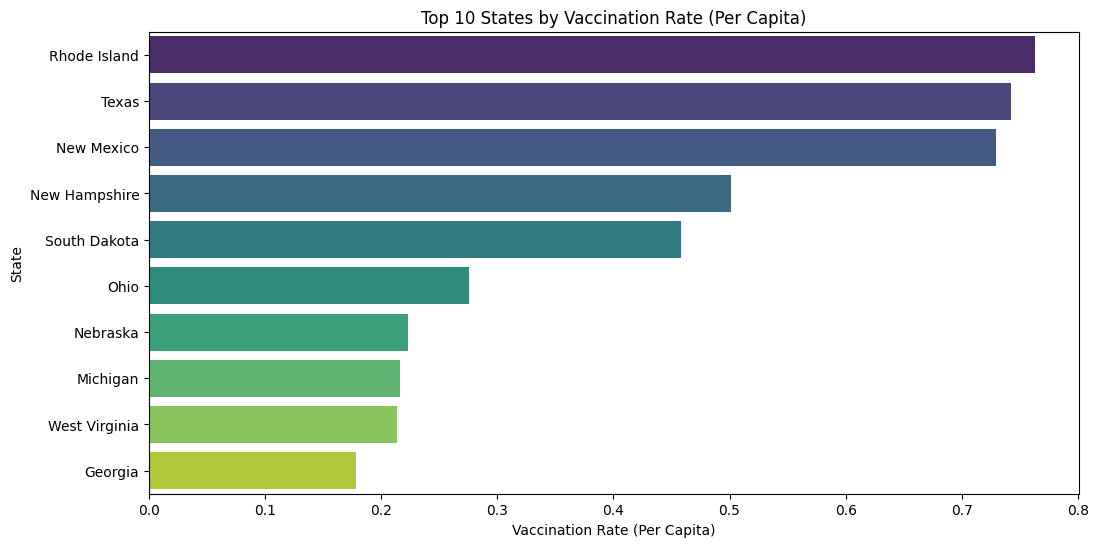

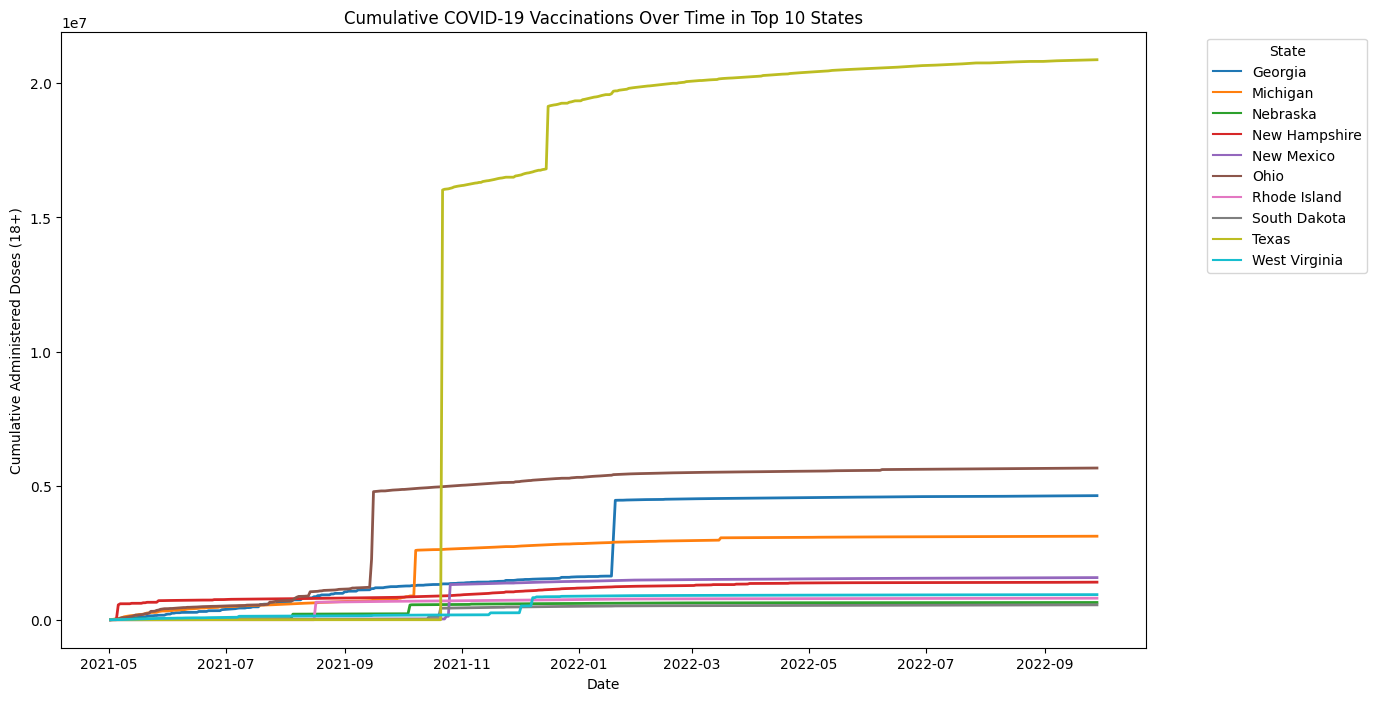

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Identifying the top 10 states by vaccination rate
# top_10_vaccination_states = df.sort_values(by='Vaccination_Rate', ascending=False).head(10)

# Horizontal bar chart for the top 10 states by vaccination rate
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_vaccination_states, x='Vaccination_Rate', y='Province_State', palette='viridis')
plt.title('Top 10 States by Vaccination Rate (Per Capita)')
plt.xlabel('Vaccination Rate (Per Capita)')
plt.ylabel('State')
plt.show()

In [ ]:
# Filtering the dataset for the top 10 states
top_states_data = df[df['Province_State'].isin(top_10_vaccination_states['Province_State'])]

# Calculating cumulative doses for each state over time
top_states_cumulative = top_states_data.groupby(['Date', 'Province_State']).sum().groupby('Province_State').cumsum().reset_index()

# Line plot for cumulative doses over time in top 10 states
plt.figure(figsize=(14, 8))
sns.lineplot(data=top_states_cumulative, x='Date', y='Administered_Doses_18Plus_Daily', hue='Province_State', palette='tab10', lw=2)
plt.title('Cumulative COVID-19 Vaccinations Over Time in Top 10 States')
plt.xlabel('Date')
plt.ylabel('Cumulative Administered Doses (18+)')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
df.columns

Index(['Date', 'State_FIPS', 'Administered_Doses_65Plus_Daily',
       'Series_Complete_65Plus_Daily', 'Booster_Doses_18Plus_Daily',
       'Series_Complete_18Plus_Daily', 'Administered_Doses_18Plus_Daily',
       'Census2019_18PlusPop', 'Deaths', 'Confirmed', 'Province_State', 'FIPS',
       'Lat', 'Long_'],
      dtype='object')

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

# Aggregating data at the national level for each day
daily_national = df.groupby('Date').sum()

# Calculating 7-day rolling averages for vaccinations and deaths
daily_national['Rolling_Avg_Vaccinations'] = daily_national['Series_Complete_18Plus_Daily'].rolling(window=21).mean()
daily_national['Rolling_Avg_Deaths'] = daily_national['Deaths'].rolling(window=21).mean()

# Creating a figure with a secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Adding vaccination data to the primary y-axis
fig.add_trace(
    go.Scatter(x=daily_national.index, y=daily_national['Rolling_Avg_Vaccinations'],
               mode='lines', name='21-Day Avg Vaccinations'),
    secondary_y=False,
)

# Adding death data to the secondary y-axis
fig.add_trace(
    go.Scatter(x=daily_national.index, y=daily_national['Rolling_Avg_Deaths'],
               mode='lines', name='21-Day Avg Deaths', line=dict(color='red')),
    secondary_y=True,
)

fig.update_layout(
    title='21-Day Rolling Average of COVID-19 Vaccinations and Deaths',
    xaxis_title='Date',
    template='plotly_dark'
)

fig.update_yaxes(title_text="Vaccinations (21-Day Avg)", secondary_y=False)
fig.update_yaxes(title_text="Deaths (21-Day Avg)", secondary_y=True)

fig.show()

<ipython-input-14-17e50956b497>:9: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [ ]:
statewise_daily = df.groupby(['Date', 'Province_State', 'FIPS', 'Lat', 'Long_']).sum().reset_index()

# Creating an interactive map using Plotly
fig = px.scatter_geo(statewise_daily,
                     lat='Lat', lon='Long_',
                     color='Series_Complete_18Plus_Daily',
                     size='Deaths',
                     hover_name='Province_State',
                     animation_frame='Date',
                     scope='usa',
                     title='Daily Statewise COVID-19 Vaccination and Deaths (Interactive Map)',
                     size_max=30)

# Updating layout
fig.update_layout(template='plotly_dark')

# Due to the limitations of this environment, the map might not render here
# You can run this code in your local Python environment to generate the interactive map
fig.show()

In [ ]:
mdf  = pd.read_csv("final_merged_df.csv")

In [ ]:
mdf.head()

,Date,State_FIPS,Administered_Doses_65Plus_Daily,Series_Complete_65Plus_Daily,Booster_Doses_18Plus_Daily,Series_Complete_18Plus_Daily,Administered_Doses_18Plus_Daily,Census2019_18PlusPop,Deaths,Confirmed,Province_State,FIPS,Lat,Long_
0,2021-05-02,10,0.0,0.0,0.0,0.0,0.0,770192.0,0,288,Delaware,10,39.3185,-75.5071
1,2021-05-02,11,0.0,0.0,0.0,0.0,0.0,577581.0,1,103,District of Columbia,11,38.8974,-77.0268
2,2021-05-02,12,0.0,0.0,0.0,0.0,0.0,17247808.0,29,3841,Florida,12,27.7663,-81.6868
3,2021-05-02,13,0.0,0.0,0.0,0.0,0.0,8113542.0,0,1302,Georgia,13,33.0406,-83.6431
4,2021-05-02,15,0.0,0.0,0.0,0.0,0.0,1116004.0,0,112,Hawaii,15,21.0943,-157.4983


In [ ]:
# Group by state and calculate the total deaths
total_deaths_per_state = mdf.groupby("Province_State", as_index=False)["Deaths"].sum()

# Get the top 10 states with the most deaths
top_10_most_deaths = total_deaths_per_state.nlargest(10, "Deaths")

# Get the top 10 states with the least deaths
top_10_least_deaths = total_deaths_per_state.nsmallest(10, "Deaths")

# Print the top 10 states with the most deaths
print("Top 10 states with the most deaths:")
print(top_10_most_deaths[["Province_State", "Deaths"]])

# Print the top 10 states with the least deaths
print("\nTop 10 states with the least deaths:")
print(top_10_least_deaths[["Province_State", "Deaths"]])

Top 10 states with the most deaths:
    Province_State  Deaths
2          Florida   40873
38           Texas   38564
32    Pennsylvania   20846
3          Georgia   20076
29            Ohio   19263
16        Michigan   17984
26        New York   17808
37       Tennessee   14824
7         Illinois   14416
27  North Carolina   13877

Top 10 states with the least deaths:
          Province_State  Deaths
1   District of Columbia     251
4                   Guam     253
40               Vermont     472
28          North Dakota     817
34          Rhode Island     933
36          South Dakota    1055
45               Wyoming    1117
5                 Hawaii    1203
23         New Hampshire    1295
0               Delaware    1352


In [ ]:
# Group by state and calculate cumulative deaths
cumulative_deaths_per_state = mdf.groupby(["Date", "Province_State"], as_index=False)["Deaths"].sum()

# Filtering data for the top 10 and bottom 10 states
top_10_states = top_10_most_deaths["Province_State"]
bottom_10_states = top_10_least_deaths["Province_State"]

top_10_data = cumulative_deaths_per_state[cumulative_deaths_per_state["Province_State"].isin(top_10_states)]
bottom_10_data = cumulative_deaths_per_state[cumulative_deaths_per_state["Province_State"].isin(bottom_10_states)]

# Calculate cumulative sum for each state
top_10_data["Cumulative Deaths"] = top_10_data.groupby("Province_State")["Deaths"].cumsum()
bottom_10_data["Cumulative Deaths"] = bottom_10_data.groupby("Province_State")["Deaths"].cumsum()

# Create cumulative line graph for the top 10 states
fig = px.line(top_10_data, x="Date", y="Cumulative Deaths", color="Province_State",
              title="Cumulative Death Rates - Top 10 States",
              labels={"Cumulative Deaths": "Cumulative Deaths", "Date": "Date"})
fig.show()

# Create cumulative line graph for the bottom 10 states
fig = px.line(bottom_10_data, x="Date", y="Cumulative Deaths", color="Province_State",
              title="Cumulative Death Rates - Bottom 10 States",
              labels={"Cumulative Deaths": "Cumulative Deaths", "Date": "Date"})
fig.show()

<ipython-input-32-a405747c1017>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-32-a405747c1017>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
mdf["Sum_Deaths"] = mdf.groupby(["Province_State"])["Deaths"].transform("sum")

dw = mdf[mdf['Province_State'] == 'Delaware']
dw

,Date,State_FIPS,Administered_Doses_65Plus_Daily,Series_Complete_65Plus_Daily,Booster_Doses_18Plus_Daily,Series_Complete_18Plus_Daily,Administered_Doses_18Plus_Daily,Census2019_18PlusPop,Deaths,Confirmed,Province_State,FIPS,Lat,Long_,Sum_Deaths
0,2021-05-02,10,0.0,0.0,0.0,0.0,0.0,770192.0,0,288,Delaware,10,39.3185,-75.5071,1352
46,2021-05-03,10,116.0,147.0,0.0,1184.0,1030.0,770192.0,0,158,Delaware,10,39.3185,-75.5071,1352
92,2021-05-04,10,136.0,195.0,0.0,2305.0,1185.0,770192.0,0,137,Delaware,10,39.3185,-75.5071,1352
138,2021-05-05,10,329.0,535.0,0.0,4538.0,2437.0,770192.0,2,197,Delaware,10,39.3185,-75.5071,1352
184,2021-05-06,10,6.0,8.0,0.0,143.0,137.0,770192.0,1,171,Delaware,10,39.3185,-75.5071,1352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19366,2022-08-31,10,104.0,107.0,577.0,419.0,443.0,770192.0,0,216,Delaware,10,39.3185,-75.5071,1352
19412,2022-09-07,10,58.0,58.0,342.0,192.0,239.0,770192.0,2,145,Delaware,10,39.3185,-75.5071,1352
19458,2022-09-14,10,96.0,37.0,73.0,90.0,212.0,770192.0,0,175,Delaware,10,39.3185,-75.5071,1352
19504,2022-09-21,10,688.0,608.0,2112.0,1635.0,1826.0,770192.0,2,216,Delaware,10,39.3185,-75.5071,1352


In [ ]:
response = requests.get("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json")
geojson_string = response.text
gdf = gpd.read_file(geojson_string)
gdf

,id,name,density,geometry
0,01,Alabama,94.650,"POLYGON ((-87.35930 35.00118, -85.60667 34.984..."
1,02,Alaska,1.264,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691..."
2,04,Arizona,57.050,"POLYGON ((-109.04250 37.00026, -109.04798 31.3..."
3,05,Arkansas,56.430,"POLYGON ((-94.47384 36.50186, -90.15254 36.496..."
4,06,California,241.700,"POLYGON ((-123.23326 42.00619, -122.37885 42.0..."
5,08,Colorado,49.330,"POLYGON ((-107.91973 41.00391, -105.72895 40.9..."
6,09,Connecticut,739.100,"POLYGON ((-73.05353 42.03905, -71.79931 42.022..."
7,10,Delaware,464.300,"POLYGON ((-75.41409 39.80446, -75.50720 39.683..."
8,11,District of Columbia,10065.000,"POLYGON ((-77.03526 38.99387, -76.90929 38.895..."
9,12,Florida,353.400,"POLYGON ((-85.49714 30.99754, -85.00421 31.003..."


In [ ]:
merged_df = gdf.merge( mdf[['Province_State','Sum_Deaths']], left_on="name", right_on="Province_State", how="right")

NameError: ignored

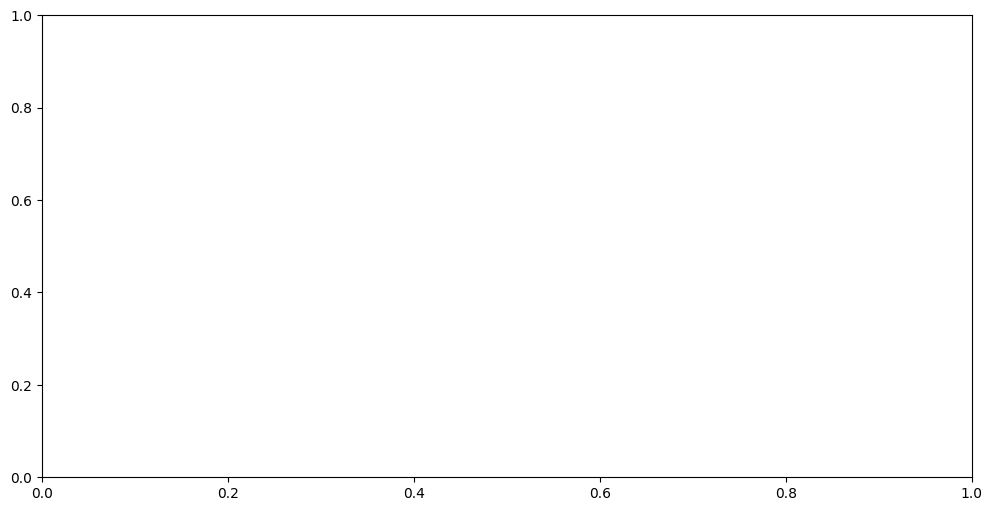

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

merged_df.plot(column='Sum_Deaths', cmap='YlOrRd', legend=True, ax=ax, linewidth=0.8, edgecolor='0.8', k=10)

ax.set_title('Total Deaths by U.S. State', fontsize=16)  # Adjust the font size
ax.set_xlabel('Longitude', fontsize=14)  # Adjust the font size
ax.set_ylabel('Latitude', fontsize=14)  # Adjust the font size

if ax.get_legend():
    # Move the legend to a better position
    legend = ax.get_legend()
    legend.set_bbox_to_anchor((1, 1))
    legend.set_title('Sum_Deaths', fontsize=12)

    legend.set_fontsize(10)

# Set the font size for the colorbar
cbar = ax.get_figure().get_axes()[1]
cbar.tick_params(labelsize=10)
ax.set_axis_off()

plt.show()

# **MLFlow Part**

In [ ]:
with mlflow.start_run(run_name="MLflow on Colab"):
  mlflow.log_metric("m1", 2.0)
  mlflow.log_param("p1", "mlflow-colab")

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.4 MB/s eta 0:00:00


In [ ]:
!wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

In [ ]:
!unzip -qq ngrok-stable-linux-amd64.zip

In [ ]:
get_ipython().system_raw('./ngrok http 5000 &')

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://31be-34-32-240-133.ngrok.io


In [ ]:
# Terminate open tunnels if exist
ngrok.kill()

# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2ZTKYXxVsRWw3ymiU72x2coBNLp_6ZpWv9AKXAedTtteQ6gun"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://9c06-34-32-240-133.ngrok-free.app


RANDOM FOREST

---


In [ ]:
merged_df = pd.read_csv('final_merged_df.csv')
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df['DayOfYear'] = merged_df['Date'].dt.dayofyear

features = ['DayOfYear', 'Confirmed', 'Administered_Doses_18Plus_Daily', 'Series_Complete_18Plus_Daily']
X = merged_df[features]

# Target variable
y = merged_df['Deaths']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Set the MLflow tracking URI to the address where the server is running
mlflow.set_tracking_uri('http://localhost:5000')

with mlflow.start_run():
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Log model and parameters
    mlflow.sklearn.log_model(model, "random_forest_model")
    mlflow.log_params({"model_type": "random_forest", "n_estimators": 100})

    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)

    # Log metrics
    mlflow.log_metric("mse", mse)

    # End the MLflow run is implicit when using the context manager

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning:

Setuptools is replacing distutils.



In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)

print(f"Mean Squared Error: {mse}")

In [ ]:
new_data = pd.DataFrame({
    'DayOfYear': [100],
    'Confirmed': [1000],
    'Administered_Doses_18Plus_Daily': [5000],
    'Series_Complete_18Plus_Daily': [3000]
})
predicted_deaths = model.predict(new_data)

print(f"Predicted Deaths: {predicted_deaths[0]}")

SARIMA MODEL

---

In [ ]:
# Perform Augmented Dickey-Fuller test
result = adfuller(daily_deaths.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Interpretation
if result[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p, d, q = 1, 1, 1  # Initial guess, adjust based on ACF and PACF plots
P, D, Q, S = 1, 1, 1, 7  # Assuming a weekly seasonality

sarima_model = SARIMAX(daily_deaths,
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, S),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit()

print(sarima_result.summary())

In [ ]:
merged_df['Deaths_log'] = np.log(merged_df['Deaths'] + 1)

daily_deaths_log = merged_df['Deaths_log'].resample('D').sum()

model = SARIMAX(daily_deaths_log,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 7),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()

# Model diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Ljung-Box test
ljung_box, p_value = acorr_ljungbox(results.resid)
print(f'Ljung-Box test: {ljung_box[:10]}')
print(f'p-values: {p_value[:10]}')

# Forecasting
forecast = results.get_forecast(steps=30)
forecast_conf_int = forecast.conf_int()
forecast_predicted_mean = forecast.predicted_mean

# Transform back if necessary
forecast_predicted_mean = np.exp(forecast_predicted_mean) - 1

plt.figure(figsize=(10, 6))
plt.plot(forecast_predicted_mean, label='Forecast')
plt.fill_between(forecast_conf_int.index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.title('30-Day Forecast')
plt.legend()
plt.show()



In [ ]:
forecasted_values = np.exp(forecast_predicted_mean) - 1

# Check the transformed forecasted values
print(forecasted_values)

plt.figure(figsize=(10, 6))
plt.plot(forecasted_values, label='Forecast')
plt.title('30-Day Forecast')
plt.legend()
plt.show()

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

residuals = results.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals from SARIMAX Model')
plt.show()

# Check for autocorrelation in residuals
plot_acf(residuals)
plt.show()

In [ ]:
test_df = pd.read_csv('final_merged_df.csv')

test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df.set_index('Date', inplace=True)

# The 'Deaths' column should contain the actual observed death counts
actual_values = test_df['Deaths']

In [ ]:
# Residual Analysis
residuals = results.resid

plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals from SARIMAX Model')
plt.show()

# Calculate and plot autocorrelation of residuals
plot_acf(residuals)
plt.show()

forecast_values = np.exp(forecast_predicted_mean) - 1 # revert log transformation if used
mae = np.mean(np.abs(forecast_values - actual_values))
rmse = np.sqrt(np.mean((forecast_values - actual_values) ** 2))
print(f'MAE: {mae}, RMSE: {rmse}')

# Plot forecast against actual values
plt.figure(figsize=(10, 6))
plt.plot(forecast_values, label='Forecast')
plt.plot(actual_values, label='Actual')
plt.title('Forecast vs Actual')
plt.legend()
plt.show()

# **Feature engineering**

In [ ]:
merged_df = pd.read_csv('final_merged_df.csv')
merged_df.head()

In [ ]:
null_percentage = (merged_df.isnull().sum() / len(merged_df)) * 100
print(null_percentage)

In [ ]:
#Percentage of population who got 1 dose
merged_df['Perc_OneDose'] = (merged_df['Administered_Doses_18Plus_Daily'] * 100) / merged_df['Census2019_18PlusPop'].round()

#Percentage of population who got 2 doses
merged_df['Perc_BothDoses'] = (merged_df['Series_Complete_18Plus_Daily'] * 100) / merged_df['Census2019_18PlusPop'].round()

In [ ]:
# As Virgin Islands has rows where the census pop is 0, removing the virgin ishlands data entirely
merged_df=merged_df[merged_df["Province_State"]!='Virgin Islands'].reset_index()
merged_df.head()

In [ ]:
# Checking if Virgin islands data has been removed
merged_df["Province_State"].unique()

## Missing Data from June 17th 2022

In [ ]:
merged_df.Date.unique()

#### We observed that cdc data is not providing every day's data from June 17th 2022. Therefore, we will be using the data tile June 16th 2022 for training and testing the model and predict from June 17th 2022 to Septmeber 2022.

In [ ]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Filter rows until June 16th, 2022
merged_df = merged_df[merged_df['Date'] <= '2022-06-16']

merged_df.tail(10)

In [ ]:
# Find the minimum and maximum values of 'Deaths'
min_deaths = merged_df['Deaths'].min()
max_deaths = merged_df['Deaths'].max()

print(f"Minimum Deaths: {min_deaths}")
print(f"Maximum Deaths: {max_deaths}")

In [ ]:
# Remove duplicates based on Date and State
df_unique = merged_df.drop_duplicates(subset=['Date', 'Province_State'])

statewise_daily_deaths = df_unique.groupby(['Date', 'Province_State'])['Deaths'].sum().reset_index()
statewise_daily_deaths
df_unique

## Time Series Data

In [ ]:
deaths_df = merged_df.groupby(['Date'])['Deaths'].sum().reset_index()
deaths_df

In [ ]:
deaths_df.describe()

In [ ]:
#Changing the Date column datatype
deaths_df['Date'] = pd.to_datetime(deaths_df['Date'])
deaths_df.sort_values('Date', inplace=True)
deaths_df.dtypes

In [ ]:
# Set Date as index
deaths_df.set_index('Date', inplace=True)

## Aggregating date level data

In [ ]:
# Aggregating date level data
date_level_df = merged_df.groupby(['Date']).agg({
    'Administered_Doses_18Plus_Daily' : 'sum' ,
    'Series_Complete_18Plus_Daily' : 'sum' ,
    'Census2019_18PlusPop' : 'sum' ,
    'Deaths': 'sum'
}).reset_index()
date_level_df.head()

In [ ]:
#Percentage of population who got 1 dose
date_level_df['Perc_OneDose'] = (date_level_df['Administered_Doses_18Plus_Daily'] * 100) / date_level_df['Census2019_18PlusPop'].round()

#Percentage of population who got 2 doses
date_level_df['Perc_BothDoses'] = (date_level_df['Series_Complete_18Plus_Daily'] * 100) / date_level_df['Census2019_18PlusPop'].round()

date_level_df.head()

# **Models**

---




## Train and Test Split

In [ ]:
# Splitting the data into train and test data
train_end = pd.to_datetime('2022-03-30')
train_data = deaths_df[deaths_df.index <= train_end]
test_data = deaths_df[deaths_df.index > train_end]

In [ ]:
test_data

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(deaths_df, label='Daily Deaths')
plt.title('Daily Deaths Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.legend()
plt.show()

## **Base Model**

In [ ]:
# Define the ARIMA model parameters (p, d, q)
p = 1  # Autoregressive order
d = 1  # Differencing order
q = 1  # Moving average order

arima_model = ARIMA(train_data, order=(p, d, q))
arima_result = arima_model.fit()

print(arima_result.summary())

# Plot the original time series and the fitted values
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(arima_result.fittedvalues, color='red', label='Fitted Values')
plt.title('ARIMA Model - Training Data')
plt.legend()
plt.show()

In [ ]:
forecast_result = arima_result.get_forecast(steps=len(test_data))
conf_int = forecast_result.conf_int()

In [ ]:
# Make predictions on the test data
forecast = arima_result.forecast(steps=len(test_data))

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, forecast, color='green', label='ARIMA Forecast')
plt.fill_between(test_data.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2, label='Confidence Interval')
plt.title('ARIMA Model - Test Data Forecast')
plt.legend()
plt.show()

### ***ARIMA Model***

#### Validation dataset:
- auto_arima from the pmdarima library typically employs a stepwise approach for model selection, internally using a validation set without explicitly splitting the provided data into train and validation sets.

In [ ]:
# Use auto_arima to find the best ARIMA model
arima_model = auto_arima(train_data, suppress_warnings=True, seasonal=False, m=7)
arima_model.fit(train_data)

forecast, conf_int = arima_model.predict(n_periods=len(test_data), return_conf_int = True)
#conf_int = arima_model.forecast(steps=len(test_data)).conf_int()

# Plot the test data and the predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_data, label='Test Data')
plt.plot(forecast, color='green', label='ARIMA Forecast')
plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2, label='95% Confidence Interval')
plt.title('ARIMA Model - Test Data Forecast')
plt.legend()
plt.show()

In [ ]:
#plot the predictions for validation set
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(forecast, label='Prediction')
plt.title("ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Deaths")
plt.legend()
plt.show()

In [ ]:
# Get the model parameters
order = arima_model.order
seasonal_order = arima_model.seasonal_order

print("ARIMA Order:", order)
print("Seasonal Order:", seasonal_order)

In [ ]:
rmse = sqrt(mean_squared_error(test_data,forecast))
print("RMSE: ",round(rmse,2))

mae = mean_absolute_error(test_data, forecast)
print(f"Mean Absolute Error: {mae:.4f}")

In [ ]:
pd.DataFrame(test_data).describe()

### ***SARIMA Model***

#### Validation dataset:
- auto_arima from the pmdarima library typically employs a stepwise approach for model selection, internally using a validation set without explicitly splitting the provided data into train and validation sets.

In [ ]:
# Use auto_arima to find the best SARIMA model
sarima_model = auto_arima(train_data, suppress_warnings=True,error_action='ignore', seasonal=True, m=7)

sarima_model.fit(train_data)

# Make predictions on the test data
sarima_forecast, conf_int = sarima_model.predict(n_periods=len(test_data), return_conf_int=True)

plt.figure(figsize=(12, 6))
plt.plot(test_data, label='Test Data')
plt.plot(sarima_forecast, color='green', label='SARIMA Forecast')
plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2, label='95% Confidence Interval')
plt.title('SARIMA Model - Test Data Forecast')
plt.legend()
plt.show()

In [ ]:
#plot the predictions for validation set
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(sarima_forecast, label='Prediction')
plt.title("SARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Deaths")
plt.legend()
plt.show()

In [ ]:
# Get the model parameters
order = sarima_model.order
seasonal_order = sarima_model.seasonal_order

print("ARIMA Order:", order)
print("Seasonal Order:", seasonal_order)

In [ ]:
rmse = sqrt(mean_squared_error(test_data,sarima_forecast))
print("RMSE: ",round(rmse,2))

mae = mean_absolute_error(test_data, sarima_forecast)
print(f"Mean Absolute Error: {mae:.4f}")

In [ ]:
pd.DataFrame(test_data).describe()

## ***Regression Model***

In [ ]:
# Checking if the number of rows in the date level data and number of unque dates in the merged_df is the same
print("Number of rows in the date level data: ",date_level_df.shape[0])
print("Number of unique dates in the merged_df: ",merged_df["Date"].nunique())

### Regression using date and double doses count

- y = ax1 + bx2
- deaths = a*date + b*Series_Complete_18Plus_Daily

In [ ]:
date_level_df['Date'] = pd.to_datetime(date_level_df['Date'])
date_level_df.sort_values(by='Date', inplace=True)

# Create lagged features for 'Number of Doses' with lag 1 and lag 2
date_level_df['BothDoses_Lag1'] = date_level_df['Series_Complete_18Plus_Daily'].shift(1)  # Lag 1: Shift previous value by 1
date_level_df['BothDoses_Lag7'] = date_level_df['Series_Complete_18Plus_Daily'].shift(7)  # Lag 7: Shift previous value by 7

# Drop rows with NaN resulting from the shift operation
date_level_df.dropna(inplace=True)

# Now, 'date_level_df' contains lagged values of 'Number of Doses' in 'Doses_Lag1' and 'Doses_Lag2'
date_level_df.head()

In [ ]:
train_data = date_level_df[date_level_df["Date"] <= '2022-03-30']
test_data = date_level_df[date_level_df["Date"] > '2022-03-30']

# Features and target variable for train and test sets
X_train = train_data[['Series_Complete_18Plus_Daily','BothDoses_Lag1','BothDoses_Lag7']]  # Features
y_train = train_data['Deaths']  # Target variable
X_test = test_data[['Series_Complete_18Plus_Daily','BothDoses_Lag1','BothDoses_Lag7']]
y_test = test_data['Deaths']

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict using the trained model on test data
y_pred = lr_model.predict(X_test)

# Calculate R^2 score for the test data
test_r2 = r2_score(y_test, y_pred)
print(f"Test R^2 score using Linear Regression model: {test_r2:.4f}")

In [ ]:
# Plotting forecast vs. actual
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', marker='o')
plt.plot(y_test.index, y_pred, label='Forecast', linestyle='dashed', marker='o')
plt.title('Forecast vs. Actual Deaths')
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.legend()
plt.show()

### Regression using all the features

In [ ]:
date_level_df['Date'] = pd.to_datetime(date_level_df['Date'])
date_level_df.set_index('Date', inplace=True)  # Set 'Date' column as index

In [ ]:
X = date_level_df.drop('Deaths', axis=1)  # Features
y = date_level_df['Deaths']  # Target variable

train_data = date_level_df[date_level_df.index <= '2022-03-30']
test_data = date_level_df[date_level_df.index > '2022-03-30']

# Features and target variable for train and test sets
X_train = train_data.drop('Deaths', axis=1)
y_train = train_data['Deaths']
X_test = test_data.drop('Deaths', axis=1)
y_test = test_data['Deaths']

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict using the trained model on test data
y_pred = lr_model.predict(X_test)

# Calculate R^2 score for the test data
test_r2 = r2_score(y_test, y_pred)
print(f"Test R^2 score using Linear Regression model: {test_r2:.4f}")

### Regression model using 3 top features

In [ ]:
# Feature selection using SelectKBest with f_regression scoring function
selector = SelectKBest(score_func=f_regression, k=3)  # Select top 3 features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)


In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train_selected, y_train)

# Predict using the trained model on test data
y_pred = lr_model.predict(X_test_selected)

# Calculate R^2 score for the test data
test_r2 = r2_score(y_test, y_pred)
print(f"Test R^2 score using Linear Regression model: {test_r2:.4f}")

In [ ]:
# Get selected feature names
selected_feature_names = X.columns[selector.get_support(indices=True)]
print(f"Selected Features: {selected_feature_names}")

#### - No regression models are observed to be working well.

## ***LSTM***

In [ ]:
df = deaths_df.copy()

In [ ]:
# Extracting 'Deaths' column as the target variable
data = df['Deaths'].values.reshape(-1, 1)

# Normalize the data (scaling between 0 and 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Define a function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        X.append(seq)
        y.append(label)
    return np.array(X), np.array(y)

# Define sequence length and create sequences
sequence_length = 7
X, y = create_sequences(scaled_data, sequence_length)

In [ ]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape data for LSTM input [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

In [ ]:
# Predict using the trained model on test data
predicted = model.predict(X_test)

# Inverse transform predictions to original scale
predicted = scaler.inverse_transform(predicted)
y_test = scaler.inverse_transform(y_test)

In [ ]:
# Get the indices starting from '2022-03-31'
start_date = '2022-03-31'

# Create a range of dates for the x-axis
date_range = pd.date_range(start=start_date, periods=len(y_test), freq='D')

# Plotting predictions vs. actual with dates on the x-axis
plt.figure(figsize=(10, 6))
plt.plot(date_range, y_test, label='Actual', marker='o')
plt.plot(date_range, predicted, label='Predicted', linestyle='dashed', marker='o')
plt.title('LSTM Predictions vs. Actual Deaths')
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.xticks(rotation=45)  # for better readability
plt.legend()
plt.tight_layout()  # to prevent overlapping labels
plt.show()

In [ ]:
mse = mean_squared_error(y_test, predicted)

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.4f}")

mae = mean_absolute_error(y_test, predicted)
print(f"Mean Absolute Error: {mae:.4f}")

# Forecasting the daily deaths from June 17th 2022 to September 2022


- Here, we are using the entire data,i.e., upto June 16th 2022 to run the best models that we found above and forecast the daily deaths from June 17th to September 30th 2022.

## Predicting daily deaths from June 17th 2022 to September 2022

- In the earlier model evaluation, we observed that SARIMA and LSTM have performed well.
- Therefore, we will use those models and predict for the next dates.

In [ ]:
# Splitting the data into train and test data
train_end = pd.to_datetime('2022-06-16')
train_data = deaths_df[deaths_df.index <= train_end]

In [ ]:
train_data

### ARIMA Model


In [ ]:
from datetime import datetime

# Define the start and end dates
start_date = datetime(2022, 6, 17)
end_date = datetime(2022, 9, 30)  # End of September 2022

# Calculate the number of days between the dates
num_days = (end_date - start_date).days + 1  # Adding 1 to include both start and end dates

print(f"Number of days between June 17th and end of September 2022: {num_days} days")

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Replace 'time_series_data' with your actual time series data
# Initialize and fit the ARIMA model
model = ARIMA(train_data, order=(2, 1, 4))
arima_model = model.fit()

# Make predictions on the test data
forecast = arima_model.forecast(steps=num_days)

# Plot the test data and the predicted values
plt.figure(figsize=(12, 6))
plt.plot(forecast, label='17th June 2022 - Septemeber 2022')
plt.title('ARIMA Model - Forecast')
plt.legend()
plt.show()

In [ ]:
#plot the predictions
plt.figure(figsize=(10,10))
plt.plot(train_data, label='Train')
plt.plot(forecast, label='Prediction')
plt.title("ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Deaths")
plt.legend()
plt.show()

NameError: ignored

### SARIMA Model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Initialize and fit the SARIMA model
model = SARIMAX(train_data, order=(2, 1, 2), seasonal_order=(2, 0, 1, 7))
sarima_model = model.fit(disp=-1,freq='D')

# Make predictions on the test data
sarima_forecast = sarima_model.forecast(steps=num_days)

In [ ]:
# Plot the test data and the predicted values
plt.figure(figsize=(12, 6))
plt.plot(sarima_forecast, label='17th June 2022 - Septemeber 2022')
plt.title('SARIMA Model - Forecast')
plt.legend()
plt.show()

In [ ]:
#plot the predictions
plt.figure(figsize=(10,10))
plt.plot(train_data, label='Train')
plt.plot(sarima_forecast, label='Prediction')
plt.title("SARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Deaths")
plt.legend()
plt.show()

### LSTM

In [ ]:
df = deaths_df.copy()

In [ ]:
# Extracting 'Deaths' column as the target variable
data = df['Deaths'].values.reshape(-1, 1)

# Normalize the data (scaling between 0 and 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Define a function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        X.append(seq)
        y.append(label)
    return np.array(X), np.array(y)

# Define sequence length and create sequences
sequence_length = 10
X, y = create_sequences(scaled_data, sequence_length)

# Reshape data for LSTM input [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model using the entire dataset
model.fit(X, y, epochs=50, batch_size=32, verbose=1)

# Predicting next 100 days
future_predictions = []
last_sequence = scaled_data[-sequence_length:]  # Last sequence from the data

for _ in range(100):
    # Reshape the last sequence for prediction
    current_sequence = last_sequence.reshape((1, sequence_length, 1))

    # Predict the next day's value
    next_pred = model.predict(current_sequence)[0]
    future_predictions.append(next_pred)

    # Update the last sequence by removing the first element and appending the predicted value
    last_sequence = np.append(last_sequence[1:], next_pred)

# Inverse transform predictions to original scale
predicted_values = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generating future dates for the next 100 days
last_date = df.index[-1]  # Assuming the last date in the dataset is the latest
future_dates = pd.date_range(start=last_date, periods=100, freq='D')

predicted_df = pd.DataFrame(predicted_values, index=future_dates, columns=['Predicted_Deaths'])

In [ ]:
# Plotting the entire dataset
plt.figure(figsize=(10, 10))
plt.plot(df.index, df['Deaths'], label='Actual Data', marker='o', linestyle='-')

# Plotting the forecasted values
plt.plot(predicted_df.index, predicted_df['Predicted_Deaths'], label='Forecasted', marker='o', linestyle='--')

plt.title('Actual vs Forecasted Deaths')
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Plotting the entire dataset
plt.figure(figsize=(10, 10))

# Plotting the forecasted values
plt.plot(predicted_df.index, predicted_df['Predicted_Deaths'], label='Forecasted', marker='o', linestyle='--')

plt.title('Forecasted Deaths')
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ***Assessing Model Drift***

- Here, we are checking the possibility of model drift.

## Train and Test Split

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(deaths_df, label='Daily Deaths')
plt.title('Daily Deaths Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.legend()
plt.show()

- The data exhibits no discernible trend or seasonality, displaying evolving patterns over time. This variability suggests a potential risk of model drift.
- Continuous monitoring of RMSE (Root Mean Square Error) following model creation is essential.
- Additionally, regularly updating the training data with new observations is advisable to mitigate this drift. Let's substantiate these points below.

## Checking the possibility of model drift

In [ ]:
# Splitting the data into train and test data
train_end = pd.to_datetime('2022-02-28')
train_data = deaths_df[deaths_df.index <= train_end]
test_data = deaths_df[deaths_df.index > train_end]

In [ ]:
test_data

## ARIMA Model

In [ ]:
# Use auto_arima to find the best ARIMA model
arima_model = auto_arima(train_data, suppress_warnings=True, seasonal=False, m=7)

arima_model.fit(train_data)

forecast, conf_int = arima_model.predict(n_periods=len(test_data), return_conf_int = True)
#conf_int = arima_model.forecast(steps=len(test_data)).conf_int()

plt.figure(figsize=(12, 6))
plt.plot(test_data, label='Test Data')
plt.plot(forecast, color='green', label='ARIMA Forecast')
plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2, label='95% Confidence Interval')
plt.title('ARIMA Model - Test Data Forecast')
plt.legend()
plt.show()

In [ ]:
#plot the predictions for validation set
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(forecast, label='Prediction')
plt.title("ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Deaths")
plt.legend()
plt.show()

- Previously, training the model with data up to June 30, 2022, led to predictions closely aligning with the actual test data. This was influenced by a pattern shift that began around March 2022(which was included in train data) and persisted throughout the test data.

- When the model was trained using data only up to February 2022, it missed capturing the new patterns or changes that emerged after that timeframe. Consequently, during testing with data exhibiting a different pattern post-February 2022, the model couldn't adjust. As a result, its predictions mirrored the patterns present in the training data, failing to adapt to the evolving trends seen in the test data.

- This emphasizes the significance of using current and relevant training data, particularly in time series forecasting where patterns can shift over time. Incorporating recent data helps the model learn from the most up-to-date patterns and enhances its ability to adapt to changes, as evidenced in the earlier case where training data included information up to June 30, 2022.

In [ ]:
rmse = sqrt(mean_squared_error(test_data,forecast))
print("RMSE: ",round(rmse,2))

mae = mean_absolute_error(test_data, forecast)
print(f"Mean Absolute Error: {mae:.4f}")